## Conditional DCGAN (cDCGAN) ##

This notebook adapts the DCGAN from the previous notebook to be used for Fashion MNIST and also to condition the generation of content. One challenge with GANs is their mapping between the latent vector and what is generated, as well as for the user to "force" the generator to create the wanted content.

#### CONDITIONS COME TO RESCUE! ####

cGAN allows us to train the model by sampling from the latent vector and combining it with the 

<img src="../figures/cGAN.png" width="600">

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
from os import listdir
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from collections import Counter
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize, Scale
from torchvision import transforms
from torchvision.datasets import MNIST, KMNIST, FashionMNIST, ImageFolder
from matplotlib import pyplot as plt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True}

raw_fashion_dataset = FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


C:\Anaconda3\envs\pDL\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
print(raw_fashion_dataset.class_to_idx)
print(raw_fashion_dataset.classes)

NUM_CLASSES = len(raw_fashion_dataset.class_to_idx)
# print(dict(Counter(raw_fashion_dataset.targets)))

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, n_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.conditional_part = nn.Sequential(
            nn.Embedding(n_classes, 50),
            nn.Linear(50, nz)
        )
        
        # input is Z x 2 (beacause of conditional input), going into a convolution
        self.layer_0 = nn.ConvTranspose2d( nz * 2, ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False)
        self.layer_1 = nn.BatchNorm2d(ngf * 8)
        self.layer_2 = nn.ReLU(True)

        # state size. (ngf*8) x 4 x 4
        self.layer_3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size = 4, stride = 2, padding = 0, bias=False)
        self.layer_4 = nn.BatchNorm2d(ngf * 4)
        self.layer_5 = nn.ReLU(True)
#             self.layer_0 = 
#             self.layer_0 = # state size. (ngf*4) x 8 x 8
        self.layer_6 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size = 4, stride = 2, padding = 0, bias=False)
        self.layer_7 = nn.BatchNorm2d(ngf * 2)
        self.layer_8 = nn.ReLU(True)
#             self.layer_0 = 
#             self.layer_0 = # state size. (ngf*2) x 16 x 16
        self.layer_9 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size = 4, stride = 1, padding = 0, bias=False)
        self.layer_10 = nn.BatchNorm2d(ngf)
        self.layer_11 = nn.ReLU(True)
#             self.layer_0 = 
#             self.layer_0 = # state size. (ngf) x 32 x 32
        self.layer_12 = nn.ConvTranspose2d( ngf, nc, kernel_size = 4, stride = 1, padding = 0, bias=False)
        self.layer_13 = nn.Tanh()
#             self.layer_0 = # state size. (nc) x 64 x 64

    def forward(self, x, conditional_input):
        
        _x = self.conditional_part(conditional_input)        
        _x = _x.unsqueeze(dim=2).unsqueeze(dim=3)
        x_combined = torch.cat([x, _x], 1)
        
        x = self.layer_0(x_combined)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)

        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)

        x = self.layer_7(x)
        x = self.layer_8(x)
        x = self.layer_9(x)

        x = self.layer_10(x)
        x = self.layer_11(x)
        x = self.layer_12(x)

        x = self.layer_13(x)   
        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, n_classes, image_size):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu        
        self.img_size = image_size
        
        self.conditional_part = nn.Sequential(
            nn.Embedding(n_classes, 50),
            nn.Linear(50, image_size * image_size)
        )
        
        self.layer_0 = nn.Conv2d(nc + 1, ndf, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.layer_1 = nn.LeakyReLU(0.2, inplace=True)
        
        # state size. (ndf) x 32 x 3
        self.layer_2 = nn.Conv2d(ndf, ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.layer_3 = nn.BatchNorm2d(ndf * 2)
        self.layer_4 = nn.LeakyReLU(0.2, inplace=True)
        
        # state size. (ndf*2) x 16 x 16
        self.layer_5 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.layer_6 = nn.BatchNorm2d(ndf * 4)
        self.layer_7 = nn.LeakyReLU(0.2, inplace=True)
        
        # state size. (ndf*4) x 8 x 8
        self.layer_8 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.layer_9 = nn.BatchNorm2d(ndf * 8)
        self.layer_10 = nn.LeakyReLU(0.2, inplace=True)
        
        # state size. (ndf*8) x 4 x 4
        self.layer_11 = nn.Conv2d(ndf * 8, 1, kernel_size = 1, stride = 1, padding = 0, bias=False) # Solved the issue with kernel size = 1
        self.layer_12 = nn.Sigmoid()

    def forward(self, x, conditional_input):
        
        # this needs to change from [128] - [128, 50] - [128, img_size * 2] - [128, 1, img_size, img_size]
        _x = self.conditional_part(conditional_input)
        _x = _x.view(-1, 1, self.img_size, self.img_size)
        x_combined = torch.cat([x, _x], 1)

        x = self.layer_0(x_combined)

        x = self.layer_1(x)
        x = self.layer_2(x)

        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)

        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)

        x = self.layer_9(x)
        x = self.layer_10(x)
        x = self.layer_11(x)

        x = self.layer_12(x)
#         print(x.shape)
        
        return x


In [11]:
# Training Loop
def train(netD, netG, optimizerD, optimizerG, criterion, num_epochs=20, print_intervals = 50, store_intervals = 100):
    print("Starting Training Loop...")
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(train_loader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            real_labels = data[1].to(device) # Actual real labels to be input into 
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            # Forward pass real batch through D
            output = netD(real_cpu, real_labels).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors       
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            gen_labels = torch.randint(low=0, high=NUM_CLASSES, size=(b_size,), device=device) # Generate the fake labels for the netG

            # Generate fake image batch with G (pass noise and pass the fake label!)
            fake = netG(noise, gen_labels)
            label.fill_(fake_label)

            # Classify all fake batch with D (also pass the random labels!)
            output = netD(fake.detach(), gen_labels).view(-1)

            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)

            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost

            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake, gen_labels).view(-1)

            # Calculate G's loss based on this output
            errG = criterion(output, label)

            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()

            # Update G
            optimizerG.step()

            # Output training stats
            if i % print_intervals == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(train_loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % store_intervals == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise, fixed_label).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
            
    return img_list, G_losses, D_losses

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu, NUM_CLASSES, image_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

######### NOW CREATE GENERATOR ###########
# Create the generator
netG = Generator(ngpu, NUM_CLASSES).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
# print(netG)

############## NOW TRAIN!!! ###########

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_label = torch.randint(low=0, high=NUM_CLASSES, size=(64,), device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list, G_losses, D_losses = train(netD, netG, optimizerD, optimizerG, criterion, num_epochs=5)

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4170	Loss_G: 0.8332	D(x): 0.4412	D(G(z)): 0.4424 / 0.4355
[0/5][50/469]	Loss_D: 1.3625	Loss_G: 0.7372	D(x): 0.4995	D(G(z)): 0.4868 / 0.4788
[0/5][100/469]	Loss_D: 1.3564	Loss_G: 0.7374	D(x): 0.5025	D(G(z)): 0.4865 / 0.4787
[0/5][150/469]	Loss_D: 1.3363	Loss_G: 0.7450	D(x): 0.5098	D(G(z)): 0.4836 / 0.4752
[0/5][200/469]	Loss_D: 1.3383	Loss_G: 0.7586	D(x): 0.5077	D(G(z)): 0.4818 / 0.4689
[0/5][250/469]	Loss_D: 1.3541	Loss_G: 0.7440	D(x): 0.5092	D(G(z)): 0.4910 / 0.4761
[0/5][300/469]	Loss_D: 1.3493	Loss_G: 0.7533	D(x): 0.5071	D(G(z)): 0.4854 / 0.4725
[0/5][350/469]	Loss_D: 1.3447	Loss_G: 0.7548	D(x): 0.5078	D(G(z)): 0.4848 / 0.4710
[0/5][400/469]	Loss_D: 1.3271	Loss_G: 0.7723	D(x): 0.5101	D(G(z)): 0.4774 / 0.4631
[0/5][450/469]	Loss_D: 1.3379	Loss_G: 0.7587	D(x): 0.5121	D(G(z)): 0.4841 / 0.4697
[1/5][0/469]	Loss_D: 1.3550	Loss_G: 0.7524	D(x): 0.5104	D(G(z)): 0.4910 / 0.4732
[1/5][50/469]	Loss_D: 1.3388	Loss_G: 0.7710	D(x): 0.5091	D(G(z)): 

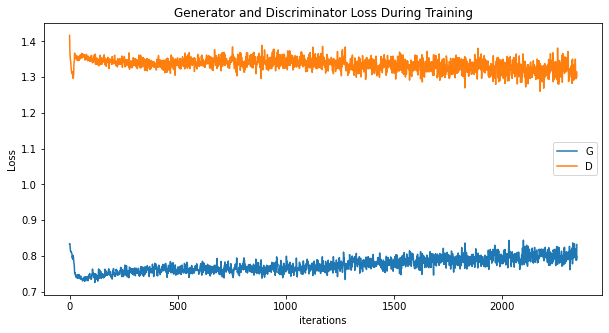

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

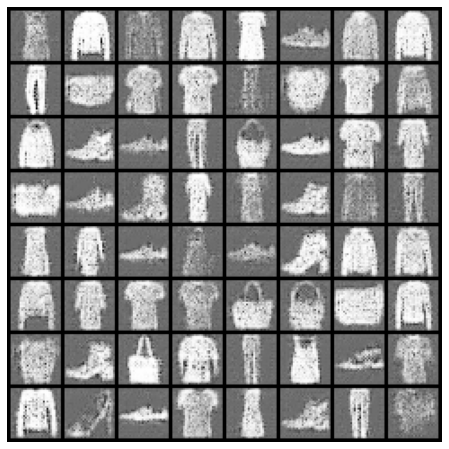

In [16]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')
torch.Size([64])
torch.Size([64, 100, 1, 1])
torch.Size([64, 1, 28, 28])


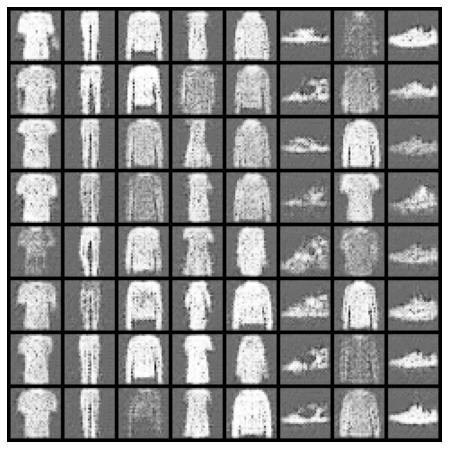

In [17]:
# Generate data based on labels!

print(raw_fashion_dataset.class_to_idx)
sample_noise = torch.randn(64, nz, 1, 1, device=device)
labels = torch.tensor([x for _ in range(8) for x in range(8)], device=device)
print(labels)
print(labels.shape)
print(sample_noise.shape)
result_imgs = []

with torch.no_grad():
    fake_imgs = netG(sample_noise, labels)

fake_imgs = fake_imgs.detach().cpu()
print(fake_imgs.shape)
result_imgs.append(vutils.make_grid(fake_imgs, padding=2, normalize=True))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in result_imgs]

In [264]:
torch.save(netD.state_dict(), "./models/CONDITIONAL-GAN/discriminator.pt")
torch.save(netG.state_dict(), "./models/CONDITIONAL-GAN/generator.pt")

In [ ]:
# LOAD THE GENERATOR AND DISCRIMINATOR FOR FURTHER USE!

netD = Discriminator()
netD.load_state_dict(torch.load("./models/GAN-70k-15epoch/discriminator.pt"))
# netD.eval() # If you want to use this already!

netG = Discriminator()
netG.load_state_dict(torch.load("./models/GAN-70k-15epoch/generator.pt"))
# netG.eval() # If you want to use this already!

----------

### Now use images to condition GAN ###

- You don't need to use this same task neither it needs to make sense
